In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt
from plot_utils import plot_numerical_diffs, plot_numerical_diffs_single

In [2]:
from src.vlstm_fwbw_v2.interface import vlstm_fwbw_torch_autogradbw
from src.vlstm_fwbw_v2.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v2.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

INCLUDE: ['/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC', '/home/max/miniconda3/envs/xlstmpt220cu121/include']
/home/max/myrepos/vlstm_cuda/src
/home/max/cpplibs/libtorch/lib:/usr/local/cuda-12.3/lib64:
/home/max/miniconda3/envs/xlstmpt220cu121/lib


Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/vlstm_fwbw_v2/build.ninja...
Building extension module vlstm_fwbw_v2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] /home/max/miniconda3/envs/xlstmpt220cu121/bin/nvcc --generate-dependencies-with-compile --dependency-output kernel_fw.cuda.o.d -ccbin /home/max/miniconda3/envs/xlstmpt220cu121/bin/x86_64-conda-linux-gnu-cc -DTORCH_EXTENSION_NAME=vlstm_fwbw_v2 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERS

Loading extension module vlstm_fwbw_v2...


In [3]:
# non tensor core version:
# ptxas info    : 136 bytes gmem
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 77 registers, 448 bytes cmem[0]
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 77 registers, 448 bytes cmem[0]

# tensor core version:
# ptxas info    : 136 bytes gmem
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 96 registers, 448 bytes cmem[0]
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 94 registers, 448 bytes cmem[0]

## CUDA vLSTM forward-backward 

Choose large tile sizes.

### Get gpu_info

In [4]:
from src.gpu_info.gpu_info import get_gpu_info

In [5]:
# get_gpu_info(0)

### define inputs

In [6]:
S = 128 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 96 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [7]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(1) #TODO from here: with seed=0 even the pytorch version alone breaks for float16 and bfloat16
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# qs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# # vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 100.
# # vs = torch.zeros((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# vs[:,:,1,0] = 7.
# qs[:,:,1,0] = 1.

# vs[:,:,1,16] = 8.
# qs[:,:,1,16] = 1.
# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [8]:
# qs[:, :, 16,0] = 1.

In [9]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [10]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [11]:
hs_pt, n_pt, m_pt, _, matLogD_pt, matD_pt, matC_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)

In [12]:
hs_pt_half, n_pt_half, m_pt_half, _, matLogD_pt_half, matD_pt_half, matC_pt_half = vlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half, fgate_preact=fgs_half)

In [13]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matLogD_pt_bf16, matD_pt_bf16, matC_pt_bf16 = vlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16, fgate_preact=fgs_bf16)

In [14]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")

print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")


====== Full -> Half ======
fw hs match: False, max diff: 0.4127330780029297
fw n match: False, max diff: 0.07650995254516602
fw m match: False, max diff: 0.0532890260219574
fw D match: False, max diff: 0.02229440212249756
====== Full -> bfloat16 ======
fw hs match: False, max diff: 19.54820442199707
fw n match: False, max diff: 1.322603702545166
fw m match: False, max diff: 0.42647314071655273
fw D match: False, max diff: 0.24758583307266235


### match directly

In [15]:
# cuda kernel float32
# hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

In [16]:
hs_cu = hs_pt
n_cu = n_pt
m_cu = m_pt
matD_cu = matD_pt

In [17]:
s_pt_half = (qs_half @ ks_half.transpose(-2, -1)).tril()
s_pt_half.shape

torch.Size([1, 1, 128, 128])

In [18]:
def lower_triangular_block_matrix(n, block_size):
    assert n % block_size == 0
    n_blocks = n // block_size
    
    mat = torch.zeros((n, n), device=DEVICE, dtype=DTYPE)
    for i in range(n_blocks):
        mat[i*block_size:(i+1)*block_size, :(i+1)*block_size] = 1.
    return mat

In [19]:
# compute the baseline for qkv tensor core computation
ltr_bmat = lower_triangular_block_matrix(S, 16)
s_block_pt = (qs @ ks.transpose(-2, -1)) * ltr_bmat
qkv_block_pt = s_block_pt @ vs

In [20]:
# cuda kernel float16
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 128, DH: 96
NUM_WARPS:4, GMEM_LOAD_BLOCK_COLS_X:4, GMEM_LOAD_BLOCK_ROWS_Y:32
blocksxy: 1-2, threadsxy: 128-1, QtileDim: 64, KVtileDim: 64, shared_mem in bytes: 94464
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 128, bdim.y: 1
In FW-Kernel: QtileDim: 64, KVtileDim: 64


In [21]:
s_pt_half[:, :, 16:33, 16:33]

tensor([[[[  8.0859,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [-16.4844,  12.3906,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -5.7617,  11.5469,   0.7471,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  5.6562,  19.9062,   7.8242,   4.3711,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  5.3555,   3.9141,   3.0996,  -5.7695,  20.6094,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -2.2461,  19.6875, -15.0078,   0.0704,   9.1094,  -5.9531,   0.0000,   0.0000,

In [22]:
matD_cu_half[:, :, 16:33, 16:33]

tensor([[[[  8.0859,  -1.5488,   6.8945,  -9.9453,   1.4209,   0.6758,  -2.6602,   4.3555,   0.8398,   0.3945,  10.5078,  12.5547, -16.1094,  -1.2461, -21.2969, -10.1094,   0.0000],
          [-16.4844,  12.3906, -11.8281, -22.0312,  -2.3066,   2.7852, -14.2969, -11.4531,  -8.3359,  -7.1367,  16.6875,  -2.7266,   0.7998,   5.8438,  15.0625,  11.3281,   0.0000],
          [ -5.7617,  11.5469,   0.7471,   6.7617,  -6.9570,  16.7500,  -0.3140,  -3.2168,   8.3594,  -7.7539,   5.6094,  -7.9258,  13.1016,   2.5020,  -4.9219,  -7.7578,   0.0000],
          [  5.6562,  19.9062,   7.8242,   4.3711, -22.8750,   0.2751,   7.1133,  -4.3789, -18.8125,   5.5352,   4.1914,   6.3281,  18.9062, -12.6016,   7.2461,  -5.4062,   0.0000],
          [  5.3555,   3.9141,   3.0996,  -5.7695,  20.6094,  -1.1465,  -4.7266,  -0.2998,  -8.1953,  21.2969,   1.2510,   8.2188,  10.9375,  11.1641,  -6.0664,   3.3320,   0.0000],
          [ -2.2461,  19.6875, -15.0078,   0.0704,   9.1094,  -5.9531,  -2.1816,  13.5625,

In [23]:
vs_half[:, :, 48:49, :12]

tensor([[[[-0.3843, -0.7324, -0.9126, -1.3672,  1.9170, -0.0097, -1.7109, -0.0597, -0.4531, -0.3826,  1.4531, -1.0049]]]], device='cuda:0', dtype=torch.float16)

In [24]:
t1 = torch.tensor([8.3190], dtype=torch.float32, device=DEVICE)
print(t1)
print(t1.half())

tensor([8.3190], device='cuda:0')
tensor([8.3203], device='cuda:0', dtype=torch.float16)


In [25]:
qkv_block_pt[:, :, -10:, :15]

tensor([[[[  -8.9331,  226.2968,   99.5339,  172.1936,  -19.1723,  -92.4837,  196.1176, -137.8358,   -7.4742,   87.8322,  -39.8324,   47.0205,  274.7249,  173.5845, -124.8089],
          [  81.0657, -151.5468,  125.8585,  -14.0208,   24.5110,   64.6904,  187.0397,    7.9207,   -2.1187,  229.9091, -210.2964,  -21.3674,  -26.4823,   22.7863,   95.8640],
          [ 165.1210,   32.9703,  112.0313,  -60.3774, -123.2558,  -16.4222,   -8.2115,  128.7446,    3.6360,   17.3155,  -20.8665,   79.4660, -156.3195, -109.4273,  -93.5056],
          [  46.5411,  190.4178,   18.9953,  121.6045,  191.4797,   95.3280,  -35.9550, -152.4927,  -76.5321,  -30.5914,  149.2084,   47.5513,  132.6076,  -45.5365,  -57.1667],
          [  31.2823,  -39.9522, -103.7935,  200.9965,   -5.2698, -110.0885, -153.9229,   16.7765,   14.9660, -113.9798,   89.7910,  121.1193,  135.5185,  101.5350,  209.2152],
          [ -68.6763, -176.8845,  -77.8899,    6.5153,  122.3696,   -8.3924,   27.5253,   48.5586,    1.9959,  -71.

In [26]:
hs_cu_half[:, :, -10:, :15]

tensor([[[[  -8.9688,  226.2500,   99.3750,  172.2500,  -19.1250,  -92.5000,  196.1250, -137.8750,   -7.3984,   87.8125,  -39.9062,   47.0000,  274.7500,  173.6250, -124.8125],
          [  81.1250, -151.5000,  125.7500,  -14.0859,   24.4219,   64.6875,  187.0000,    7.8750,   -2.0547,  229.8750, -210.2500,  -21.4219,  -26.4375,   22.8281,   95.8125],
          [ 165.1250,   32.8438,  112.0000,  -60.3125, -123.2500,  -16.4062,   -8.2031,  128.7500,    3.6758,   17.3125,  -20.9062,   79.4375, -156.3750, -109.4375,  -93.5000],
          [  46.6250,  190.5000,   19.0312,  121.6250,  191.5000,   95.2500,  -36.0312, -152.5000,  -76.4375,  -30.6094,  149.1250,   47.5938,  132.6250,  -45.5312,  -57.1562],
          [  31.2500,  -39.8750, -103.8125,  201.0000,   -5.2891, -110.1875, -154.0000,   16.8594,   14.9766, -114.0000,   89.8750,  121.1250,  135.5000,  101.5625,  209.2500],
          [ -68.7500, -176.8750,  -77.9375,    6.4492,  122.3750,   -8.3750,   27.5000,   48.5625,    1.9824,  -71.

tensor(0.1918, device='cuda:0')

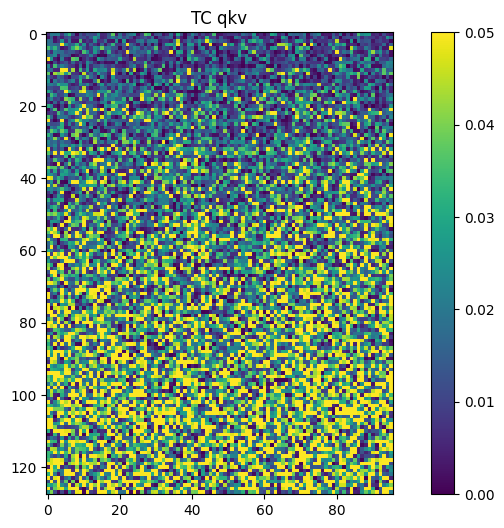

In [27]:
fig = plot_numerical_diffs_single(hs_cu_half, qkv_block_pt, title="TC qkv", vmax=0.05)
(hs_cu_half - qkv_block_pt).abs().max()

In [28]:
s_pt_half[:, :, :16, :16]

tensor([[[[  9.9297,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ 13.2578,   6.8711,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -7.4570,   7.9727,   7.3398,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -1.7695,  -0.8560,   7.5391, -16.5312,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -3.5684,  -7.4180,  -4.7344,  10.8594,  11.2266,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -2.1602,  17.6250,   8.1250, -10.1875,  -5.4180,  -4.2812,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

In [29]:
matD_cu_half[:, :, :10, 0:17]

tensor([[[[ 9.9297e+00, -4.9570e+00,  3.1465e+00, -1.2812e+00,  4.9219e+00, -1.6672e+01, -4.3555e+00, -4.2266e+00, -4.9883e+00, -4.9375e+00, -9.2031e+00,  1.3234e+01,  6.6992e-01, -5.7109e+00,
           -6.0938e+00, -1.3047e+01,  0.0000e+00],
          [ 1.3258e+01,  6.8711e+00,  1.4656e+01, -6.9961e+00, -1.1930e+01, -5.5977e+00,  1.4320e+01, -2.9199e+00,  1.0148e+01,  3.1914e+00, -9.3672e+00,  8.8125e+00, -2.6660e+00, -1.5109e+01,
            3.4062e+00,  7.1758e+00,  0.0000e+00],
          [-7.4570e+00,  7.9727e+00,  7.3398e+00,  1.3055e+01, -5.0273e+00,  3.9043e+00, -4.1641e+00, -9.8281e+00, -1.5211e+01, -1.1338e+00, -5.9883e+00, -1.2373e+00,  1.9756e+00,  6.5742e+00,
            1.3547e+01,  1.0336e+01,  0.0000e+00],
          [-1.7695e+00, -8.5596e-01,  7.5391e+00, -1.6531e+01, -3.1250e-01,  1.4441e-01,  7.9102e+00, -3.7910e+00,  8.3906e+00, -1.6703e+01,  2.2562e+01, -1.3701e+00, -1.0789e+01,  1.6201e+00,
           -1.2805e+01, -1.7312e+01,  0.0000e+00],
          [-3.5684e+00, 

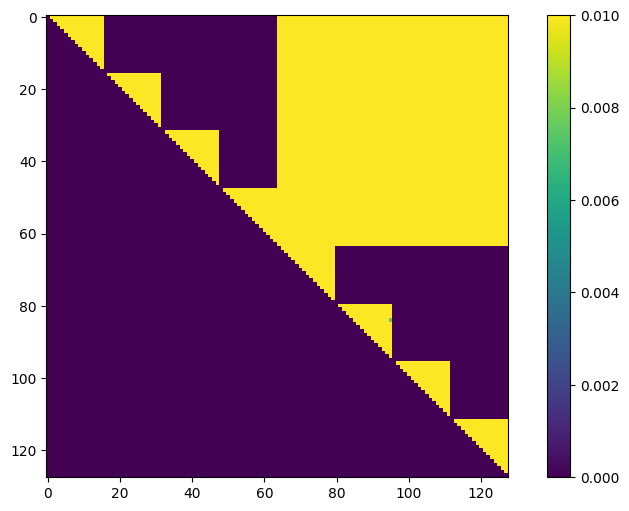

In [30]:
fig = plot_numerical_diffs_single(s_pt_half, matD_cu_half)

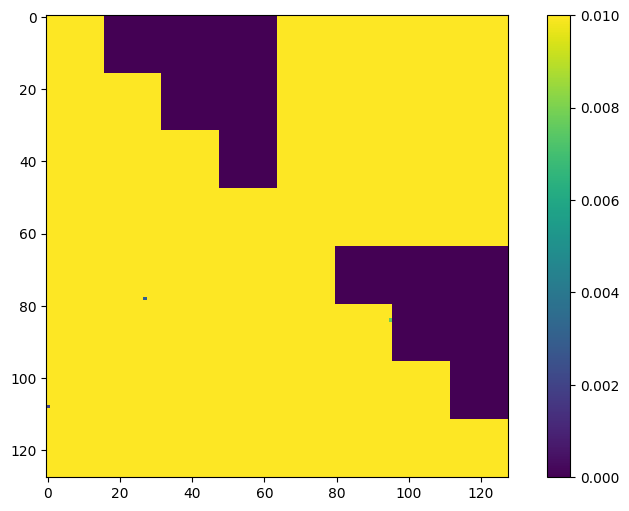

In [31]:
fig = plot_numerical_diffs_single(matD_cu_half)

In [32]:
s_pt_half[:, :, :10, :10]

tensor([[[[  9.9297,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ 13.2578,   6.8711,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -7.4570,   7.9727,   7.3398,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -1.7695,  -0.8560,   7.5391, -16.5312,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -3.5684,  -7.4180,  -4.7344,  10.8594,  11.2266,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -2.1602,  17.6250,   8.1250, -10.1875,  -5.4180,  -4.2812,   0.0000,   0.0000,   0.0000,   0.0000],
          [  2.7363,   2.5859,  -1.9131, -10.7344,  -0.1101,  -0.8018,  -1.9932,   0.0000,   0.0000,   0.0000],
          [ 23.3594,  -9.7891,   4.2969, -16.5625,  -3.8125,  -8.0938,   2.2969,   0.6074,   0.0000,   0.0000],
          [  1.1357, -12.4688,   8.1328,   0.2302,   5.8672, -10.6719,   0.4932,   4.8320, -16.7500,   0

In [33]:
(s_pt_half - matD_cu_half)[:, : , :10, :10]

tensor([[[[  0.0000,   4.9570,  -3.1465,   1.2812,  -4.9219,  16.6719,   4.3555,   4.2266,   4.9883,   4.9375],
          [  0.0000,   0.0000, -14.6562,   6.9961,  11.9297,   5.5977, -14.3203,   2.9199, -10.1484,  -3.1914],
          [  0.0000,   0.0000,   0.0000, -13.0547,   5.0273,  -3.9043,   4.1641,   9.8281,  15.2109,   1.1338],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.3125,  -0.1444,  -7.9102,   3.7910,  -8.3906,  16.7031],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   7.4922, -20.5938,  23.2188,  -4.5781, -14.0625],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -0.6582, -29.1875,  -2.3145,  -5.8281],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   9.0391, -18.1875, -12.3750],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -1.8613,   2.1211],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   5

In [34]:
(s_pt_half - matD_cu_half).abs().max()

tensor(39.5938, device='cuda:0', dtype=torch.float16)

In [35]:
vs_half[:, :, :3, 32:]

tensor([[[[ 8.4326e-01,  2.5024e-01,  1.9668e+00, -7.2607e-01, -1.2266e+00,  1.9922e-01, -1.4668e+00, -6.7188e-01, -1.1328e+00,  1.1963e+00, -2.1912e-02, -2.8015e-02, -1.1530e-01,  1.5240e-03,
            7.8857e-01,  2.9565e-01,  1.1113e+00,  9.4580e-01, -7.9980e-01,  7.6221e-01,  1.0244e+00, -1.7090e+00, -3.4009e-01, -3.1274e-01,  1.3672e+00, -7.6123e-01, -1.8396e-01, -7.4707e-01,
            6.4697e-02,  1.2637e+00,  4.2139e-01,  2.8687e-01,  2.6538e-01,  3.9307e-02,  6.1377e-01,  1.6553e+00,  1.6846e+00, -4.0112e-01, -1.2900e+00, -3.8672e-01,  2.7295e-01,  3.5864e-01,
            1.6729e+00, -2.2949e-01,  2.2217e-01,  4.6655e-01, -5.3223e-01, -7.4463e-01, -1.1768e+00, -1.0029e+00, -1.7520e+00, -8.1201e-01, -1.5161e-01,  7.7979e-01,  6.8604e-01, -1.5332e-01,
           -9.6558e-02,  5.5078e-01,  7.2314e-01, -1.8262e+00, -1.0332e+00, -1.0590e-01,  5.8740e-01, -9.9414e-01],
          [ 8.2031e-01,  2.0879e+00,  4.3188e-01,  4.7180e-02,  1.0889e+00,  2.4524e-01,  1.7053e-01, -1.2090e+0

In [36]:
matD_cu_half.shape

torch.Size([1, 1, 128, 128])

In [37]:
matD_cu_half[:, :, :10, :10]

tensor([[[[  9.9297,  -4.9570,   3.1465,  -1.2812,   4.9219, -16.6719,  -4.3555,  -4.2266,  -4.9883,  -4.9375],
          [ 13.2578,   6.8711,  14.6562,  -6.9961, -11.9297,  -5.5977,  14.3203,  -2.9199,  10.1484,   3.1914],
          [ -7.4570,   7.9727,   7.3398,  13.0547,  -5.0273,   3.9043,  -4.1641,  -9.8281, -15.2109,  -1.1338],
          [ -1.7695,  -0.8560,   7.5391, -16.5312,  -0.3125,   0.1444,   7.9102,  -3.7910,   8.3906, -16.7031],
          [ -3.5684,  -7.4180,  -4.7344,  10.8594,  11.2266,  -7.4922,  20.5938, -23.2188,   4.5781,  14.0625],
          [ -2.1602,  17.6250,   8.1250, -10.1875,  -5.4180,  -4.2812,   0.6582,  29.1875,   2.3145,   5.8281],
          [  2.7363,   2.5859,  -1.9131, -10.7344,  -0.1101,  -0.8018,  -1.9932,  -9.0391,  18.1875,  12.3750],
          [ 23.3594,  -9.7891,   4.2969, -16.5625,  -3.8125,  -8.0938,   2.2969,   0.6074,   1.8613,  -2.1211],
          [  1.1357, -12.4688,   8.1328,   0.2302,   5.8672, -10.6719,   0.4932,   4.8320, -16.7500,  -5

In [38]:
hs_cu_half[:, :, :3, 32:]

tensor([[[[ -5.1758, -56.6875,  17.9531, -23.9531, -20.6562,  15.8438, -20.9219, -13.0000,  21.6875,  -2.0957,  -1.1230,  35.9062, -15.8359,  30.4219,  29.7812, -13.4844,  26.5781,  38.1875, -38.3125,
            -9.1094,  62.9688,  -2.0684,  16.7188,  47.1562,  78.9375,  -1.1426,  -7.8672, -55.1562, -63.4375,  33.4688, -11.2031, -28.0000, -17.3125, -29.6719, -36.3438,  30.6719, -41.0312,  32.3438,
           -15.2578, -27.9531,  38.3750, -35.9375,  14.8516, -19.0625,   8.7812, -15.4297,  41.6875,   0.2449,  20.5156,  31.7344,  36.7812,   9.9922,   5.9414,  -4.5469,  19.5000,  50.6875, -17.1562,
            -7.5000,  24.3750, -12.1406,  16.7188,  12.6250, -75.1875,  39.4688],
          [ 41.4375, -53.4375,  38.0312, -29.4219, -47.8750, -60.6562,  18.3281, -37.5312, -39.8125,   8.5703,  24.5469,  -1.8506, -82.3750,  46.2500,  43.6875,  12.9297, -19.7188,  42.1250, -41.6875,
             9.9766,  -9.0469, -61.3438,  32.2500,  10.4766,   8.8906, -71.6250,  11.1719, -31.5312, -24.2656,  -0

In [39]:
(vs_half-hs_cu_half)[:, :, :3, 32:]

tensor([[[[   6.0195,   56.9375,  -15.9844,   23.2344,   19.4375,  -15.6406,   19.4531,   12.3281,  -22.8125,    3.2930,    1.1016,  -35.9375,   15.7188,  -30.4219,  -29.0000,   13.7812,  -25.4688,
            -37.2500,   37.5000,    9.8750,  -61.9375,    0.3594,  -17.0625,  -47.4688,  -77.5625,    0.3813,    7.6836,   54.4062,   63.5000,  -32.2188,   11.6250,   28.2812,   17.5781,   29.7188,
             36.9688,  -29.0156,   42.7188,  -32.7500,   13.9688,   27.5625,  -38.0938,   36.2812,  -13.1797,   18.8281,   -8.5625,   15.8984,  -42.2188,   -0.9893,  -21.6875,  -32.7500,  -38.5312,
            -10.8047,   -6.0938,    5.3281,  -18.8125,  -50.8438,   17.0625,    8.0469,  -23.6562,   10.3125,  -17.7500,  -12.7344,   75.7500,  -40.4688],
          [ -40.6250,   55.5312,  -37.5938,   29.4688,   48.9688,   60.9062,  -18.1562,   36.3125,   42.0938,   -8.1953,  -25.7500,    1.1602,   81.1250,  -46.8438,  -45.4062,  -13.2188,   19.5156,
            -41.8438,   40.4062,   -9.6953,    9.1406

In [40]:
# cuda kernel bfloat16
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 128, DH: 96
NUM_WARPS:4, GMEM_LOAD_BLOCK_COLS_X:4, GMEM_LOAD_BLOCK_ROWS_Y:32
blocksxy: 1-2, threadsxy: 128-1, QtileDim: 64, KVtileDim: 64, shared_mem in bytes: 94464
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 128, bdim.y: 1
In FW-Kernel: QtileDim: 64, KVtileDim: 64


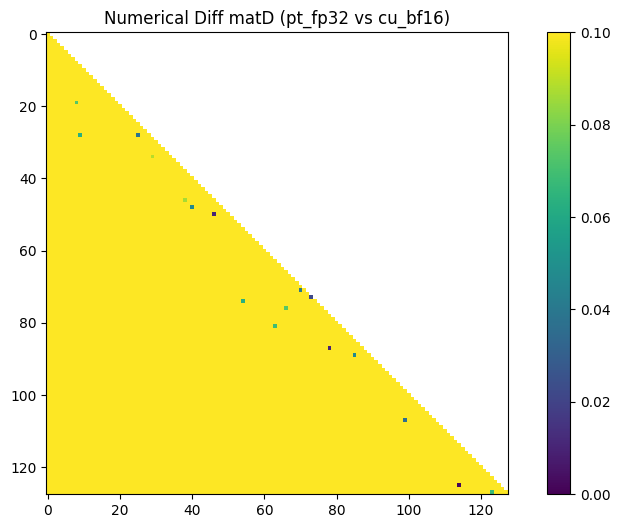

In [41]:
fig = plot_numerical_diffs_single(matLogD_pt, matD_cu_bf16, title="Numerical Diff matD (pt_fp32 vs cu_bf16)", vmax=10e-2)

In [42]:
matD_cu_bf16[:, :, :17, :16]

tensor([[[[  9.8750,  -4.9688,   3.1562,  -1.3594,   4.9375, -16.6250,  -4.3438,  -4.1875,  -4.9688,  -4.9062,  -9.1875,  13.2500,   0.6602,  -5.6562,  -6.0938, -13.0000],
          [ 13.2500,   6.8438,  14.6875,  -7.0312, -11.9375,  -5.5938,  14.3125,  -2.9531,  10.1250,   3.1562,  -9.3750,   8.7500,  -2.6562, -15.1250,   3.3750,   7.2188],
          [ -7.4688,   8.0000,   7.3750,  13.0625,  -5.0625,   3.9062,  -4.1562,  -9.7500, -15.1875,  -1.1328,  -6.0000,  -1.2578,   1.9844,   6.5625,  13.5625,  10.3125],
          [ -1.7578,  -0.8633,   7.5625, -16.5000,  -0.3418,   0.1055,   7.8750,  -3.8281,   8.4375, -16.6250,  22.6250,  -1.3828, -10.8125,   1.6250, -12.8125, -17.3750],
          [ -3.5625,  -7.4062,  -4.7188,  10.8750,  11.2500,  -7.5000,  20.6250, -23.1250,   4.5625,  14.0625,   8.5000,   8.0000,   8.6875,  13.4375,   9.8125,   2.1406],
          [ -2.1406,  17.6250,   8.1875, -10.1875,  -5.4375,  -4.2812,   0.6445,  29.1250,   2.2969,   5.8438,   1.1797,  14.3125,  -8.7500,

In [43]:
# (qs_bf16 @ ks_bf16)[:, :, :17, :16]

In [44]:
hs_cu_half.shape, qs_half.shape

(torch.Size([1, 1, 128, 96]), torch.Size([1, 1, 128, 96]))

In [45]:
hs_cu_half, qs

(tensor([[[[ 3.9395e+00, -8.7656e+00,  3.2438e+01,  2.6880e-01, -3.5039e+00,  5.8781e+01, -7.1125e+01,  2.0797e+01,  1.8984e+01,  2.0312e+01, -1.3719e+01, -6.3398e+00, -1.5117e+01,  1.2117e+01,
             1.9844e+01, -6.9727e-01,  3.0891e+01,  1.2922e+01, -3.8250e+01,  4.6156e+01,  4.0281e+01,  6.6000e+01, -2.8953e+01, -1.4969e+01, -1.0273e+01, -3.8688e+01,  5.4688e+00,  9.5125e+01,
             1.7725e+00, -1.8625e+01, -4.2344e+01, -5.5438e+01, -5.1758e+00, -5.6688e+01,  1.7953e+01, -2.3953e+01, -2.0656e+01,  1.5844e+01, -2.0922e+01, -1.3000e+01,  2.1688e+01, -2.0957e+00,
            -1.1230e+00,  3.5906e+01, -1.5836e+01,  3.0422e+01,  2.9781e+01, -1.3484e+01,  2.6578e+01,  3.8188e+01, -3.8312e+01, -9.1094e+00,  6.2969e+01, -2.0684e+00,  1.6719e+01,  4.7156e+01,
             7.8938e+01, -1.1426e+00, -7.8672e+00, -5.5156e+01, -6.3438e+01,  3.3469e+01, -1.1203e+01, -2.8000e+01, -1.7312e+01, -2.9672e+01, -3.6344e+01,  3.0672e+01, -4.1031e+01,  3.2344e+01,
            -1.5258e+01, -2.79

In [46]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matLogD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matLogD_pt).tril())}")

print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matLogD_pt).tril())}")

print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matLogD_pt).tril())}")


Match against pt float32:
====== Full ======
fw hs match: True, max diff: 0.0
fw n match: True, max diff: 0.0
fw m match: True, max diff: 0.0
fw D match: False, max diff: 105.7960205078125
====== Half ======
fw hs match: False, max diff: 384.9565734863281
fw n match: False, max diff: 3.7951691150665283
fw m match: False, max diff: 2.3591573238372803
fw D match: False, max diff: 119.73776245117188
====== bfloat16 ======
fw hs match: False, max diff: 386.2065734863281
fw n match: False, max diff: 3.7951691150665283
fw m match: False, max diff: 2.3591573238372803
fw D match: False, max diff: 119.69088745117188


In [47]:
16 / 4

4.0

In [48]:
13 % 4, 14 % 4

(1, 2)

In [49]:
# ====== Full -> bfloat16 ======
# fw hs match: False, max diff: 0.15340876579284668
# fw n match: False, max diff: 0.09692215919494629
# fw m match: False, max diff: 0.05207604169845581
# fw D match: False, max diff: 0.15224838256835938
# ---------------------------------
# bw dQs match: False, max diff: 0.13966524600982666
# bw dKs match: False, max diff: 0.13031554222106934
# bw dVs match: False, max diff: 0.09818196296691895
# bw dIgs match: False, max diff: 0.12595558166503906
# bw dFgs match: False, max diff: 0.08353292942047119

### visualize diffs

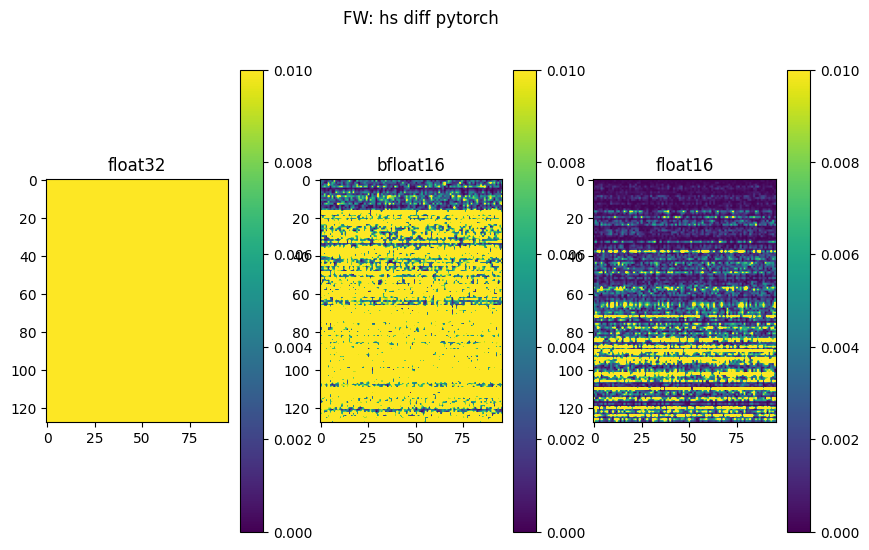

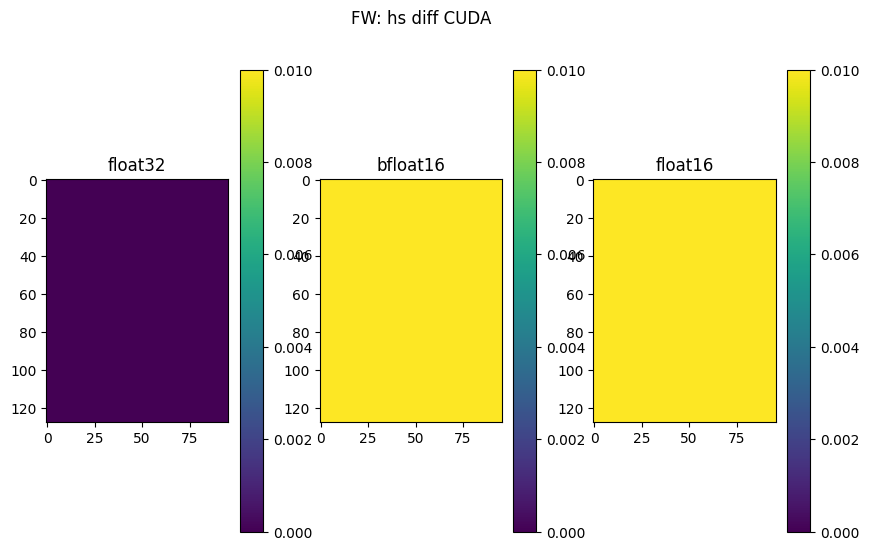

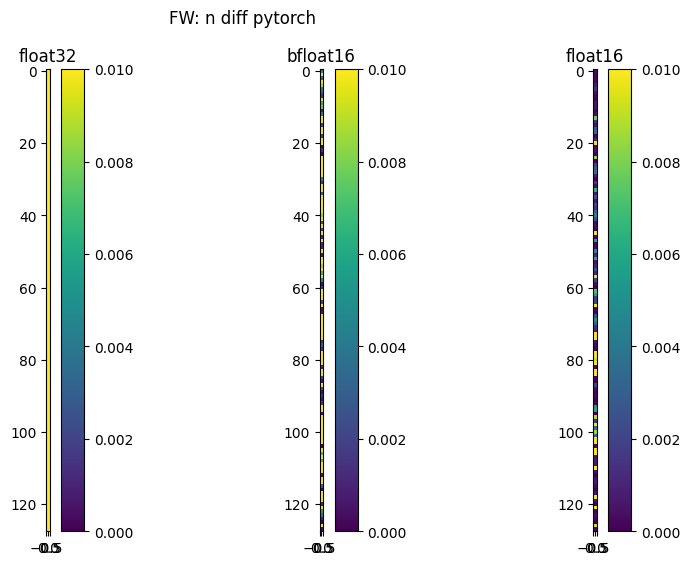

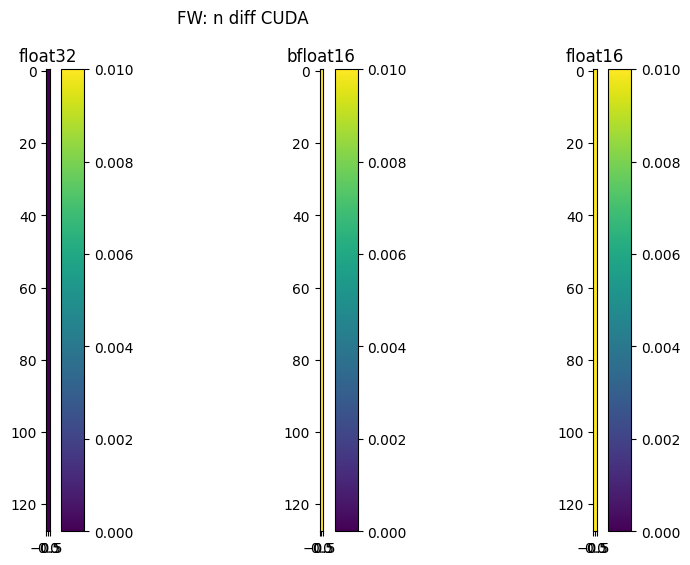

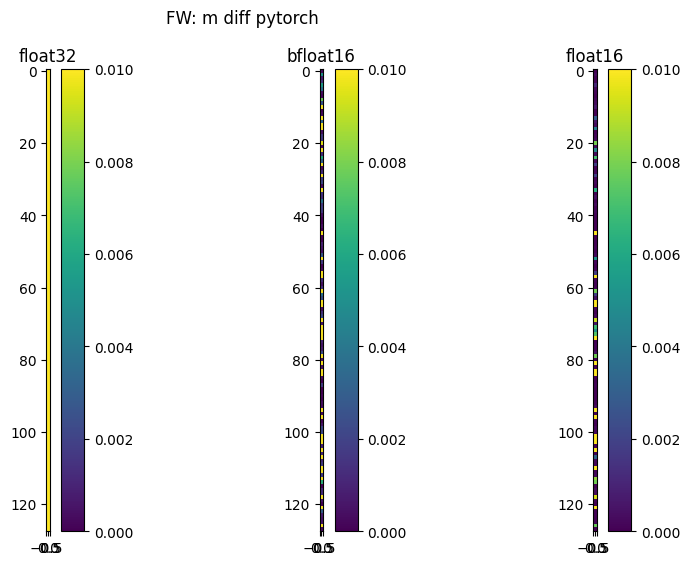

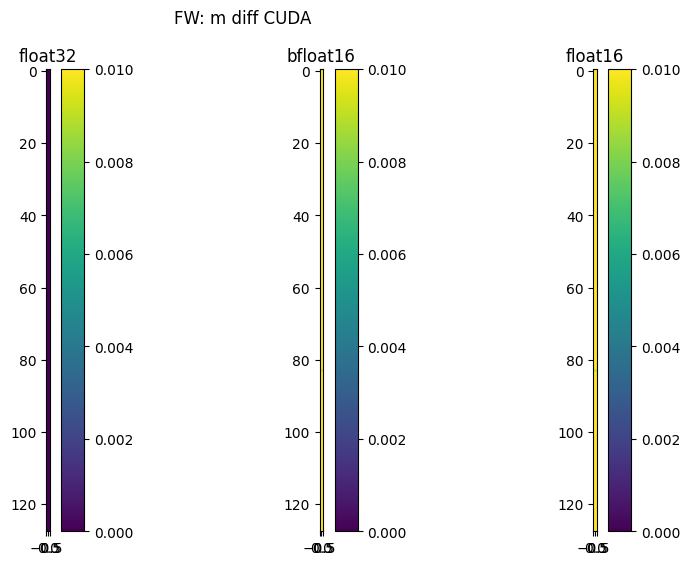

In [50]:
## fw diffs
# hs
fig = plot_numerical_diffs(hs_pt, 10*torch.ones_like(hs_pt), hs_pt_bf16, hs_pt_half, title="FW: hs diff pytorch")
fig = plot_numerical_diffs(hs_pt, hs_cu, hs_cu_bf16, hs_cu_half, title="FW: hs diff CUDA")
# n 
fig = plot_numerical_diffs(n_pt, 10*torch.ones_like(n_pt), n_pt_bf16, n_pt_half, title="FW: n diff pytorch")
fig = plot_numerical_diffs(n_pt, n_cu, n_cu_bf16, n_cu_half, title="FW: n diff CUDA")
# m
fig = plot_numerical_diffs(m_pt, 10*torch.ones_like(m_pt), m_pt_bf16, m_pt_half, title="FW: m diff pytorch")
fig = plot_numerical_diffs(m_pt, m_cu, m_cu_bf16, m_cu_half, title="FW: m diff CUDA")